In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from copy import deepcopy

In [ ]:
df = pd.read_csv("/kaggle/input/university-students-complaints-and-reports/Datasetprojpowerbi.csv")

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df['Genre'].value_counts()

# Merging values into one overview

In [ ]:
df['overview'] = df['Reports'] + " Age: " + df['Age'].astype(str) + ". GPA: " + df['Gpa'].astype(str) + ". Year: " + df['Year'].astype(str) + " . Gender: " + df['Gender'].astype(str)

In [ ]:
un = df['Genre'].unique()
j = 0
labels = dict()
for i in un:
    labels[i] = j
    j += 1

In [ ]:
df['Genre'] = df['Genre'].map(labels)

# Getting the most important features

In [ ]:
dataset = df[['Genre', 'overview']].copy()

In [ ]:
train, test = train_test_split(dataset.values, random_state=42, test_size=0.2)

# Data pipeline

In [ ]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(x):
    cat, txt = df.iloc[:, 0].values, df.iloc[:, -1].values
    for _, text in zip(cat, txt):
        yield tokenizer(text)
        
        
vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [ ]:
train_dataloader = DataLoader(train, batch_size=8, shuffle=True, collate_fn=collate_batch)
validation_loader = DataLoader(test, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Simple MLP-like Text Classification Moel

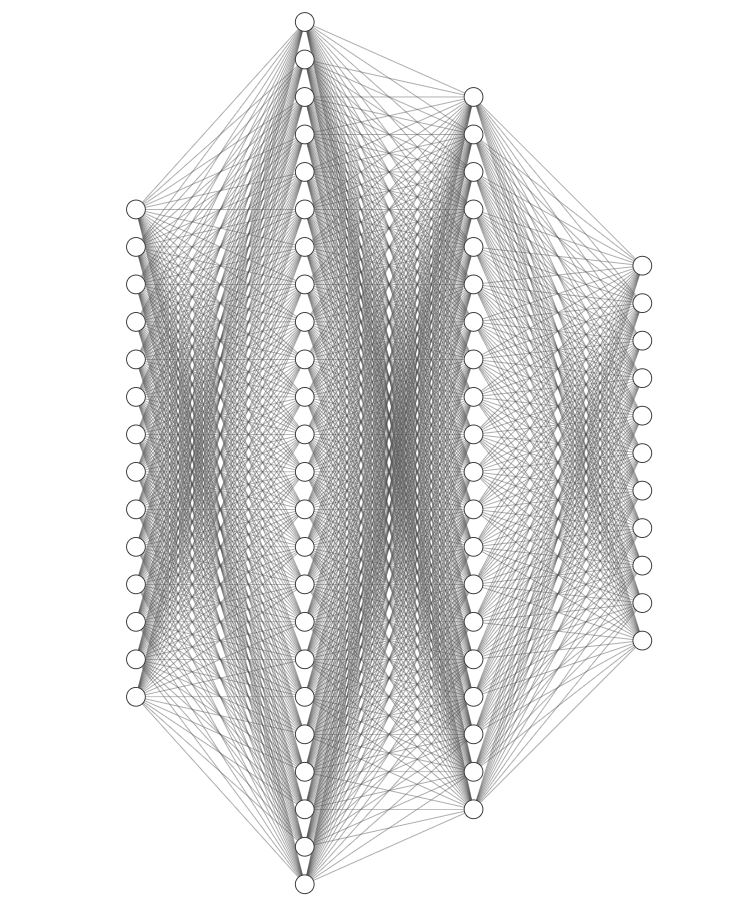

In [ ]:
class ComplaintClassification(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(ComplaintClassification, self).__init__()
        self.embed = torch.nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.layer = torch.nn.Sequential(torch.nn.Linear(embed_dim, 128),
                                        torch.nn.Linear(128, 32),
                                        torch.nn.Linear(32, num_class))
        
    def forward(self, x, off):
        x = self.embed(x, off)
        return self.layer(x)

In [ ]:
num_classes = 11
vocab_size = len(vocab)
emsize=  64
model = ComplaintClassification(vocab_size, emsize, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer is Adam and Loss is CorssEntropyLoss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Training process with validation loss

In [ ]:
EPOCHS = 15

best_model = deepcopy(model)

prev = 0

for i in range(1, EPOCHS+1):
    model.train()
    
    total_acc, total_count = 0, 0
    for label, text, offsets in train_dataloader:
        optimizer.zero_grad()
        
        output = model(text, offsets)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_acc += loss.item()
        total_count += 1
        
    print("Epoch {} training loss : {}".format(i,total_acc/total_count))
    
    model.eval()
    
    val_acc = 0
    val_count = 0
    
    with torch.no_grad():
        for label, text, offsets in validation_loader:
            output = model(text, offsets)
            
            val_acc += (output.argmax(1) == label).sum().item()
            val_count += label.size(0)
            
    acc = val_acc/val_count
    
    if acc > prev:
        best_model = deepcopy(model)
        prev = acc
            
    
    print("Epoch {} validation loss : {}".format(i, val_acc/val_count))

# Testing model to predict labels for some real world scenarios

In [ ]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

In [ ]:
reverse = dict()
for i, j in labels.items():
    reverse[j] = i

In [ ]:
val = "I cannot pay my tuition fees, because of technical issues. Age: 21. GPA: 4.62. Year: 1 . Gender: F"

reverse[predict(val, text_pipeline)]

# Afterword

Given bigger dataset with no imbalance in labels, more examples and better hardware - it could help students, especially foreign ones with navigating across University contacts and services when they need help and save them time by directing them straight to correct contact